# Examining the choice of minimum $\Delta \chi^2$ with CMX Tile 66003

Tile 66003 has 3 exposures of 450s from SV0. Using VI redshifts, I examine the choice of minimum $\Delta \chi^2 = 40$ vs $100$
by looking at the true and false positive rates and looking at their spectra and redrock fits. 


Details of the exposures can be found in [TS SV0](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0)

In [1]:
import os
import glob
import h5py
import fitsio
import numpy as np 

from redrock import templates
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read VI table
fvi = os.path.join('/global/cfs/cdirs/desi/sv/vi/TruthTables/', 'truth_table_BGS_v1.2.csv')

vi_id, ztrue, qa_flag = np.genfromtxt(fvi, delimiter=',', skip_header=1, unpack=True, usecols=[0, 2, 3])

good_z = (qa_flag >= 2.5)
vi_id = vi_id[good_z].astype(int)
ztrue = ztrue[good_z]

In [4]:
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [5]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate


def zsuccess(zrr, ztrue, zwarn, deltachi2=None, min_deltachi2=9.):
    ''' apply redshift success crition

    |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 

    :params zrr: 
        redrock best-fit redshift

    :params ztrue: 
        true redshift 

    :params zwarn: 
        zwarn flag value 

    :return crit: 
        boolean array indiciate which redshifts were successfully
        measured by redrock 
    '''
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    if deltachi2 is None: 
        crit = (dz_1pz < 0.003) & (zwarn == 0)
    else: 
        crit = (dz_1pz < 0.003) & (zwarn == 0) & (deltachi2 > min_deltachi2) 
    return crit

## $z$ success rate with $\Delta \chi^2=40$ vs $100$
Lets first see how much the redshift success rate is impacted by the choice of $\Delta \chi^2$

--- 55654 ---
  619 matches to VI
  372 successful r < 20 redshifts delta chi2=40
  356 successful r < 20 redshifts delta chi2=100
--- 55655 ---
  620 matches to VI
  372 successful r < 20 redshifts delta chi2=40
  359 successful r < 20 redshifts delta chi2=100
--- 55656 ---
  621 matches to VI
  364 successful r < 20 redshifts delta chi2=40
  340 successful r < 20 redshifts delta chi2=100


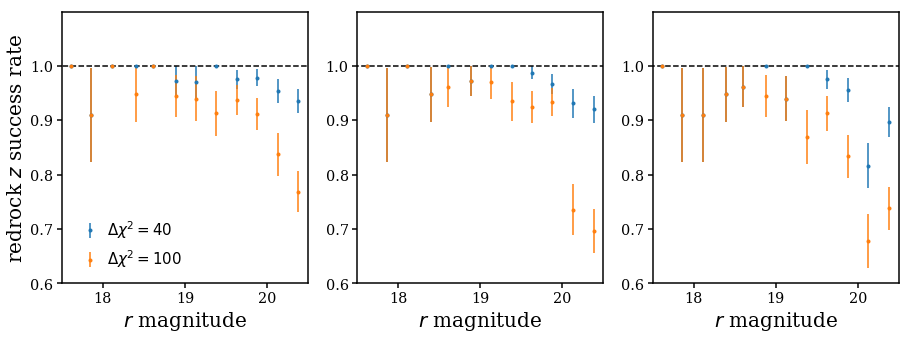

In [6]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_match = 0
    rmags, zss_dchi2_40, zss_dchi2_100 = [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
        
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)

        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        gal_cut = is_BGS & (np.sum(coadd_flux, axis=1) != 0)

        targetid = coadd['TARGETID'][gal_cut]
        _, m_vi, m_coadd = np.intersect1d(vi_id, targetid, return_indices=True)
        
        n_match += len(m_vi)

        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
    
        # read 
        f_rrock = f_coadd.replace('coadd-', 'redrock-').replace('.fits', '.h5')
        rrock = h5py.File(f_rrock, 'r')
        
        rmag = 22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut][m_coadd])
        zsuccess_dchi2_40 = zsuccess(zbest['Z'][gal_cut][m_coadd], ztrue[m_vi], zbest['ZWARN'][gal_cut][m_coadd], 
                                     deltachi2=zbest['DELTACHI2'][gal_cut][m_coadd], min_deltachi2=40)
        zsuccess_dchi2_100 = zsuccess(zbest['Z'][gal_cut][m_coadd], ztrue[m_vi], zbest['ZWARN'][gal_cut][m_coadd], 
                                      deltachi2=zbest['DELTACHI2'][gal_cut][m_coadd], min_deltachi2=100)
        
        dchi_40yes_100no = zsuccess_dchi2_40 & ~zsuccess_dchi2_100 & (rmag < 19.)
        
        rmags.append(rmag)
        zss_dchi2_40.append(zsuccess_dchi2_40)
        zss_dchi2_100.append(zsuccess_dchi2_100)
        
    print('  %i matches to VI' % n_match)
    print('  %i successful r < 20 redshifts delta chi2=40' % np.sum(np.concatenate(zss_dchi2_40) & (np.concatenate(rmags) < 20.)))
    print('  %i successful r < 20 redshifts delta chi2=100' % np.sum(np.concatenate(zss_dchi2_100) & (np.concatenate(rmags) < 20.)))
    sub = fig.add_subplot(1,3,i_exp+1)
    
    sub.plot([16, 21], [1.0, 1.0], c='k', ls='--') 
    wmean, rate, err_rate = zsuccess_rate(np.concatenate(rmags), np.concatenate(zss_dchi2_40), range=[15,22], nbins=28, bin_min=10) 
    sub.errorbar(wmean, rate, err_rate, fmt='.C0', label=r'$\Delta \chi^2 = 40$')
    wmean, rate, err_rate = zsuccess_rate(np.concatenate(rmags), np.concatenate(zss_dchi2_100), range=[15,22], nbins=28, bin_min=10) 
    sub.errorbar(wmean, rate, err_rate, fmt='.C1', label=r'$\Delta \chi^2 = 100$')
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 20.5) 

    if i_exp == 0: 
        sub.set_ylabel(r'redrock $z$ success rate', fontsize=20)
        sub.legend(loc='lower left', handletextpad=0.1, fontsize=15)

    sub.set_ylim([0.6, 1.1])
    sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.]) 


There's a **significant** impact, especially for faint galaxies: ~5% at r~19.5, ~10% at r~20.

## "true positives" with $40 < \Delta \chi^2 < 100$
Spectra where redrock got the right redshifts but with $40 < \Delta \chi^2 < 100$

In [7]:
galaxy_templates = templates.Template('rrtemplate-galaxy.fits')

DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


--- 55654 ---
  16 of 16 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives
--- 55655 ---
  13 of 13 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives
--- 55656 ---
  24 of 26 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives


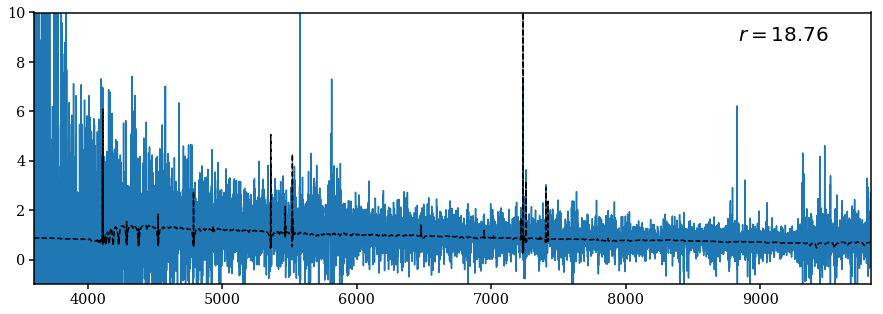

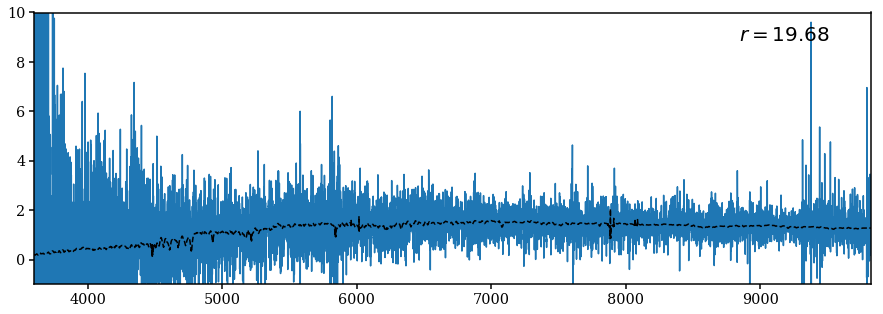

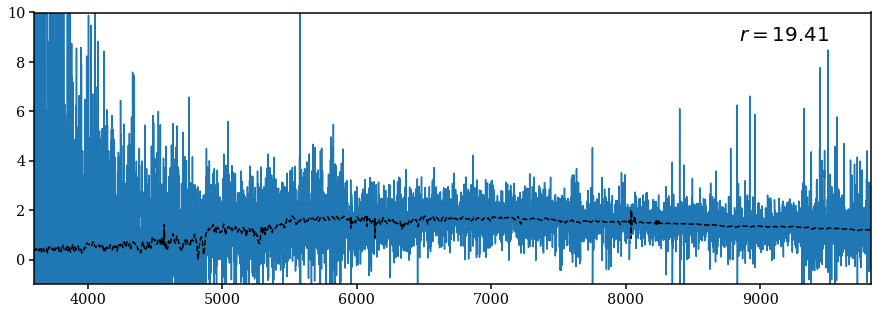

In [8]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_tp, n_pass = 0, 0
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
        
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)

        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        gal_cut = is_BGS & (np.sum(coadd_flux, axis=1) != 0)

        targetid = coadd['TARGETID'][gal_cut]
        _, m_vi, m_coadd = np.intersect1d(vi_id, targetid, return_indices=True)
        
        n_match += len(m_vi)

        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
    
        # read 
        f_rrock = f_coadd.replace('coadd-', 'redrock-').replace('.fits', '.h5')
        rrock = h5py.File(f_rrock, 'r')
        
        rmag = 22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut][m_coadd])

        dz_1pz = np.abs(ztrue[m_vi] - zbest['Z'][gal_cut][m_coadd])/(1.+ztrue[m_vi])
        true_positive = (dz_1pz < 0.003) & (zbest['ZWARN'][gal_cut][m_coadd] == 0) & (zbest['DELTACHI2'][gal_cut][m_coadd] > 40.) & (zbest['DELTACHI2'][gal_cut][m_coadd] < 100.) & (rmag < 20.)        
        n_tp += np.sum(true_positive)
        n_pass += np.sum((zbest['ZWARN'][gal_cut][m_coadd] == 0) & (zbest['DELTACHI2'][gal_cut][m_coadd] > 40.) & (zbest['DELTACHI2'][gal_cut][m_coadd] < 100.) & (rmag < 20.))
        
        if petal != petals[1]: continue 
            
        for _i, i, _rmag in zip(range(1), m_coadd[true_positive], rmag[true_positive]): 
            bestfit_template = galaxy_templates.eval(zbest['COEFF'][gal_cut][i], coadd_wave, zbest['Z'][gal_cut][i]) * (1+zbest['Z'][gal_cut][i])
            fig = plt.figure(figsize=(15,5))
            sub = fig.add_subplot(111)
            sub.plot(coadd_wave, coadd_flux[gal_cut,:][i])
            sub.plot(coadd_wave, bestfit_template, c='k', ls='--')
            sub.text(0.95, 0.95, r'$r=%.2f$' % _rmag, transform=sub.transAxes, ha='right', va='top', fontsize=20)
            sub.set_xlim(coadd_wave.min(), coadd_wave.max())
            sub.set_ylim(-1., 10)
    print('  %i of %i r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives' % (n_tp, n_pass)) 

## "false positives" with $40 < \Delta \chi^2 < 100$
Spectra that redrock *thinks* it got the right redshifts (ZWARN = 0 and $\Delta \chi^2 > 40$) but was wrong

--- 55654 ---
  0 of 16 r < 20 galaxies with ZWARN=0 40 < delta chi^2 < 100 are false positives
--- 55655 ---
  0 of 13 r < 20 galaxies with ZWARN=0 40 < delta chi^2 < 100 are false positives
--- 55656 ---
  2 of 26 r < 20 galaxies with ZWARN=0 40 < delta chi^2 < 100 are false positives


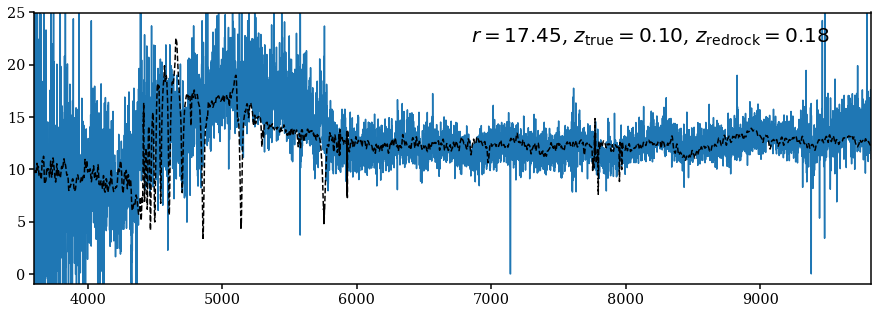

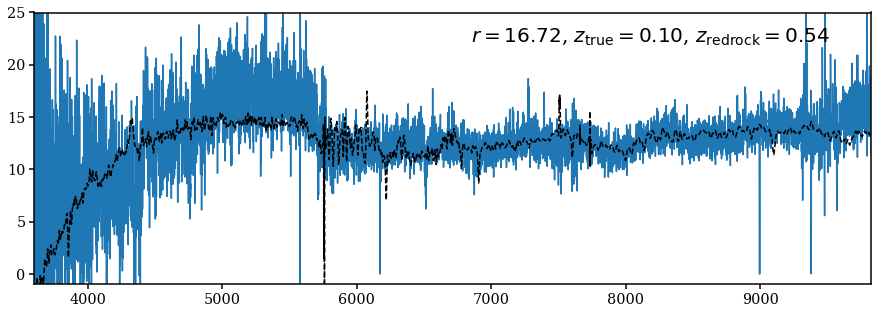

In [9]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_fp, n_pass = 0, 0
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
        
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)

        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        gal_cut = is_BGS & (np.sum(coadd_flux, axis=1) != 0)

        targetid = coadd['TARGETID'][gal_cut]
        _, m_vi, m_coadd = np.intersect1d(vi_id, targetid, return_indices=True)
        
        n_match += len(m_vi)

        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
    
        # read 
        f_rrock = f_coadd.replace('coadd-', 'redrock-').replace('.fits', '.h5')
        rrock = h5py.File(f_rrock, 'r')
        
        rmag = 22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut][m_coadd])        
        dz_1pz = np.abs(ztrue[m_vi] - zbest['Z'][gal_cut][m_coadd])/(1.+ztrue[m_vi])
        
        # deltachi2 = 40 false positives
        false_positive = (dz_1pz >= 0.003) & (zbest['ZWARN'][gal_cut][m_coadd] == 0) & (zbest['DELTACHI2'][gal_cut][m_coadd] > 40.) & (zbest['DELTACHI2'][gal_cut][m_coadd] < 100.) & (rmag < 20.)        
        n_fp += np.sum(false_positive)
        n_pass += np.sum((zbest['ZWARN'][gal_cut][m_coadd] == 0) & (zbest['DELTACHI2'][gal_cut][m_coadd] > 40.) & (zbest['DELTACHI2'][gal_cut][m_coadd] < 100.) & (rmag < 20.))
        
        for i, _rmag, _ztrue in zip(m_coadd[false_positive], rmag[false_positive], ztrue[m_vi][false_positive]): 
            bestfit_template = galaxy_templates.eval(zbest['COEFF'][gal_cut][i], coadd_wave, zbest['Z'][gal_cut][i]) * (1+zbest['Z'][gal_cut][i])
            fig = plt.figure(figsize=(15,5))
            sub = fig.add_subplot(111)
            sub.plot(coadd_wave, coadd_flux[gal_cut,:][i])
            sub.plot(coadd_wave, bestfit_template, c='k', ls='--')
            sub.text(0.95, 0.95, r'$r=%.2f$, $z_{\rm true} = %.2f$, $z_{\rm redrock} = %.2f$' % (_rmag, _ztrue, zbest['Z'][gal_cut][i]), transform=sub.transAxes, ha='right', va='top', fontsize=20)
            sub.set_xlim(coadd_wave.min(), coadd_wave.max())
            sub.set_ylim(-1., 25)
            
    print('  %i of %i r < 20 galaxies with ZWARN=0 40 < delta chi^2 < 100 are false positives' % (n_fp, n_pass)) 

Out of 55 spectra, 2 false positives